### Classifying a Kaggle dataset using PyTorch
#### CIFAR-10

In [1]:
import os
import torch
import random
import cupy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from IPython.display import clear_output
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

seed = 300900
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.set_default_device("cuda:0")
    torch.cuda.set_device("cuda:0")
    device = "cuda:0"

In [2]:
class CIFAR10Dataset(Dataset): #Our dataset class
    def __init__(self, image_folder, labels, transform=None):
        self.image_folder = image_folder
        self.labels = labels
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_folder)])

        self.transformed_images = self.apply_transformations()
        self.label_mapping = {label: i for i, label in enumerate(set(self.labels))}

    def apply_transformations(self):
        transformed_images = []
        for img_file in self.image_files:
            img_path = os.path.join(self.image_folder, img_file)
            image = Image.open(img_path)
            transformed_versions = [self.transform(image) for _ in range(4)]
            transformed_images.append(transformed_versions)

        return transformed_images

    def __len__(self) -> int:
        return len(self.image_files)
    
    def __getitem__(self, index) -> Image:
        original_index = index // 4
        version_index =  index % 4
        
        image = self.transformed_images[original_index][version_index]
        label = self.labels[int(self.image_files[original_index].replace(".png", "")) - 1]

        return image, self.label_mapping[label]
    
    def getOriginalImage(self, index) -> Image:
        original_index = index // 4
        img_path = os.path.join(self.image_folder, self.image_files[original_index])
        label = self.labels[int(self.image_files[original_index].replace(".png", "")) - 1]
        image = Image.open(img_path)

        return image, self.label_mapping[label]

    def getLabel(self, index) -> str:
        original_index = index // 4
        return self.labels[int(self.image_files[original_index].replace(".png", "")) - 1]

In [3]:
class ResNet18(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet18.fc(x)

        return x

In [4]:
def show_images(images, originals, labels):
    fig, axes = plt.subplots(2, 5, figsize=(15,6))
    
    for i in range(5):
        label = labels[i]

        axes[0, i].imshow(originals[i][0])
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        image = np.transpose(images[i].numpy(), (1,2,0))
        axes[1, i].imshow(image)
        axes[1, i].set_title(f"Transformed image, label: {label}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
all_labels = pd.read_csv("../data/cifar-10/trainLabels.csv")['label']
image_folder = "../data/cifar-10/train"

In [6]:
ds_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(60, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0] * 3, std=[1] * 3)
]) 

dataset = CIFAR10Dataset(image_folder, all_labels, transform=ds_transforms)

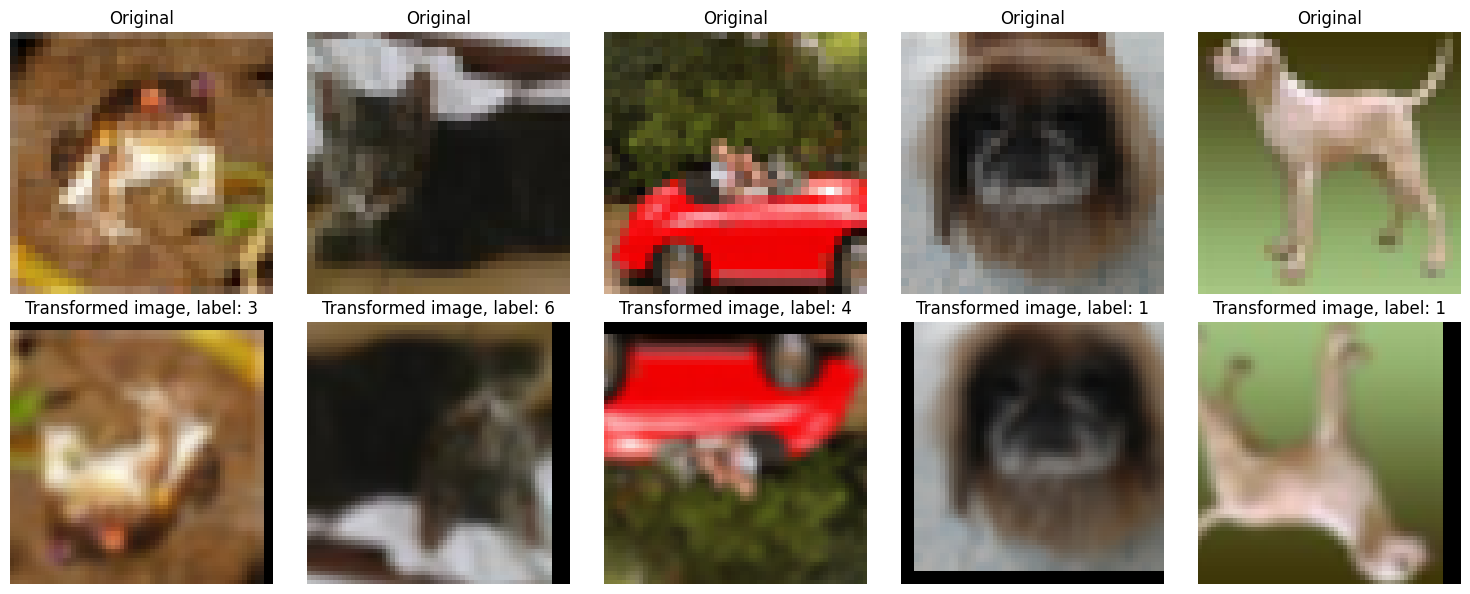

In [7]:
images = []
originals = []
labels = []
for i in [0, 4, 8, 12, 16]:
    couple = dataset[i]
    images.append(couple[0])
    labels.append(couple[1])
    originals.append(dataset.getOriginalImage(i))

show_images(images, originals, labels)

In [8]:
# Splitting indices for train, validation, and test sets
batch_size = 64

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=seed)

# Creating SubsetRandomSampler instances for train, validation, and test sets
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Creating DataLoader instances for train, validation, and test sets using the samplers
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [9]:
num_classes = len(set(all_labels))

network = ResNet18(num_classes)
loss_function = nn.CrossEntropyLoss()

In [ ]:
lr = 5e-3
momentum = 0.9

optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)

step_size = 2
gamma = 0.05
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

epochs = 10 
train_losses = []
train_accuracies = []
for epoch in range(epochs):
    
    network.train()  # Set the network to training mode
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training") as t:
        for data, target in t:
            total = 0
            correct = 0
            data = data.to(device)
            target_tensor = target.clone().detach()
            optimizer.zero_grad()  # Zero the gradients
            output = network(data)  # Forward pass
            loss = loss_function(output, target_tensor)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            train_losses.append(loss.item())

            accuracy = (correct / total)
            train_accuracies.append(accuracy)

            t.set_postfix(current_loss=loss.item(), accuracy=accuracy)
            
            # Clear the output of the cell
            clear_output(wait=True)
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('Iterations')
            ax1.set_ylabel('Loss', color=color)
            ax1.plot(train_losses, label='Training Loss', color=color)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()  # Create another y-axis sharing the same x-axis
            color = 'tab:blue'
            ax2.set_ylabel('Accuracy', color=color)
            ax2.plot(train_accuracies, label='Training Accuracy', color=color)
            ax2.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()
            plt.title('Dynamic Loss and Accuracy Plot')
            plt.show()

    # Validation steps...
    network.eval()  # Set the network to evaluation mode
    with torch.no_grad(), tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation") as v:
        for data, target in v:
            data = data.to(device)
            output = network(data)  # Forward pass
            target_tensor = target.clone().detach()
            loss = loss_function(output, target_tensor)  # Compute the loss
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            v.set_postfix( val_accuracy=(correct / total))

    # Update the learning rate
    scheduler.step()

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Val Accuracy: {(100 * correct / total):.2f}%')

In [14]:
good_guess = 0
total = 0
predictions = []
for data, target in tqdm(test_loader):
    with torch.no_grad():
        data = data.to(device)
        output = network(data)  # Forward pass
        target_tensor = target.clone().detach()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        good_guess += (predicted == target).sum().item()
        predicted = predicted.cpu().numpy()
        target = target_tensor.cpu().numpy()
        
        # Iterate over each image in the batch
        for i in range(len(data)):
            # Convert data tensor to numpy array and transpose if necessary
            img = data[i].cpu().numpy().transpose((1, 2, 0))

            predictions.append((img, predicted[i], target[i]))

print(good_guess / total)

100%|██████████| 157/157 [00:07<00:00, 21.06it/s]

0.7598


In [15]:
labels_map = list(set(all_labels))

# Define a function to display images
def display_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i, (image, prediction, target) in enumerate(images):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted: {labels_map[prediction]} \n Target: {labels_map[target]}")
        axes[i].axis('off')

    plt.show()

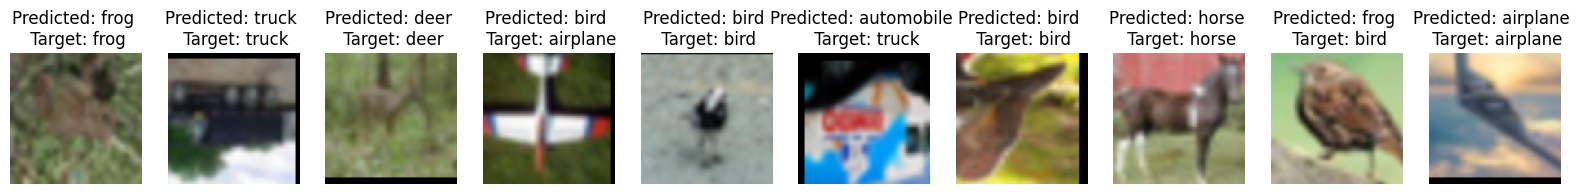

In [16]:
# Randomly select 5 samples from the predictions array
random_samples = random.sample(predictions, 10)

# Display the randomly selected samples
display_images(random_samples)